In [1]:
import random
import numpy as np
import time
import pickle
import csv

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients

In [2]:
# reading csv file
filename = "Cd_output_data.csv"
rows = []
with open(filename, 'r', encoding='utf-8-sig') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        rows.extend(row)
    print("Total no. of rows: %d"%(csvreader.line_num))
print(np.shape(np.array(rows)))
y_Cd_s = np.array(rows)
y_Cd_s = np.reshape(y_Cd_s, (240000,1)) 
y_Cd = np.zeros((240000,1))
for i in range(240000):
    for j in range(1):
        y_Cd[i,j] = float(y_Cd_s[i,j])
        
filename = "input_data.csv"
rows = []
with open(filename, 'r', encoding='utf-8-sig') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        rows.extend(row)
    print("Total no. of rows: %d"%(csvreader.line_num))
print(np.shape(np.array(rows)))
Input_s = np.array(rows)
Input_s = np.reshape(Input_s, (240000,32)) 
Input = np.zeros((240000,32))
for i in range(240000):
    for j in range(32):
        Input[i,j] = float(Input_s[i,j])


Total no. of rows: 240000
(240000,)
Total no. of rows: 240000
(7680000,)


In [3]:
print(Input.shape)

(240000, 32)


In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(Input)
# X = Input
y = y_Cd

coef_in = 10
coef_out = 1
X = X*coef_in
y = y*coef_out


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

x_tr_ts=torch.from_numpy(X_train)
y_tr_ts=torch.from_numpy(y_train)
x_te_ts=torch.from_numpy(X_test)
y_te_ts=torch.from_numpy(y_test)


x = Variable(x_tr_ts,requires_grad=True)

In [5]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = torch.nn.Linear(32,120) 
        self.linear2 = torch.nn.Linear(120,120)
        self.linear3 = torch.nn.Linear(120,120)
        self.linear4 = torch.nn.Linear(120,120)
        self.linear5 = torch.nn.Linear(120,120)
        self.linear6 = torch.nn.Linear(120,60)
        self.predict = torch.nn.Linear(60,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    
model = Model().double()

model

Model(
  (linear1): Linear(in_features=32, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=120, bias=True)
  (linear3): Linear(in_features=120, out_features=120, bias=True)
  (linear4): Linear(in_features=120, out_features=120, bias=True)
  (linear5): Linear(in_features=120, out_features=120, bias=True)
  (linear6): Linear(in_features=120, out_features=60, bias=True)
  (predict): Linear(in_features=60, out_features=1, bias=True)
)

In [6]:
x.shape

torch.Size([160800, 32])

In [7]:
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(),lr = lr)
loss_func = torch.nn.MSELoss()

h_list = []
l_list = []

tstart = time.time()


for epoch in range(500):
        # forward
        y_pred = model(x)
        loss = loss_func(y_tr_ts,y_pred)
        # print(epoch, loss.item())
        h_list.append(epoch)
        l_list.append(loss.item())
        print(epoch)

        # back propagation
        optimizer.zero_grad()
        loss.backward()

        # updating parameters
        optimizer.step()
    
tfinal1 = time.time() - tstart
print (tfinal1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

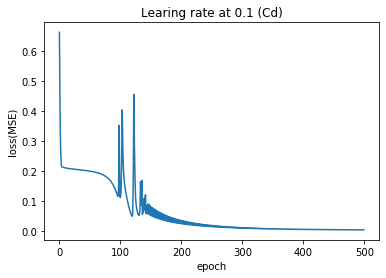

<Figure size 432x288 with 0 Axes>

In [8]:
plt.plot(np.arange(len(l_list)), l_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.title('Learing rate at %s (Cd)'%lr)
plt.show()
plt.savefig('./ourloss.jpg')

r2_score is 0.9801061545204055
MSE is 0.0041425451039273555
coef_in 10
coef_out 1
epoch 499


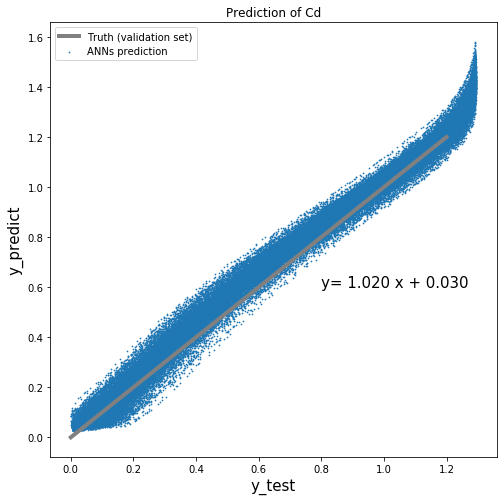

In [27]:
y_te_model=model(x_te_ts)
y_predict=y_te_model.detach().numpy()
y_predict = y_predict

plt.figure(figsize=(8,8))

# plt.xlim((0.01, 0.02))
# plt.ylim((0.01, 0.02))

plt.xlabel('y_test',fontsize=15)
plt.ylabel('y_predict',fontsize=15)


ax = y_test[:,0]
ay = y_predict[:,0]

z5 = np.polyfit(ax,ay,1)  #Linear fitting
x5 = np.arange(0, 1.2, 0.001)
y5 = x5 
plt.plot(x5, y5,'grey',linewidth=4)
plt.scatter(y_test,y_predict,s=0.5)
plt.text(0.8,0.6,'y= %.3f x + %.3f'%(z5[0],z5[1]),fontsize=15)
plt.legend(["Truth (validation set)","ANNs prediction"])
plt.title('Prediction of Cd')
r_ANN=r2_score(y_test,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)
print('coef_in %s'%coef_in)
print('coef_out %s'%coef_out)
print('epoch %s'%epoch)
plt.savefig('./ourprediction.jpg')

# plot the curve of Cd with respect to AoA

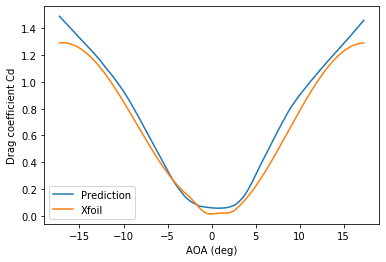

In [31]:
AoA = X[800:1200,-1]

m = X[800:1200,:]
n = y[800:1200,:]
m_ts=torch.from_numpy(m)
n_pre_ts = model(m_ts)
n_pre = n_pre_ts.detach().numpy()


plt.plot(AoA,n_pre,label = 'Prediction')
plt.plot(AoA,n,label = 'Xfoil')
plt.xlabel("AOA (deg)")
plt.ylabel("Drag coefficient Cd")
plt.legend()
#plt.title('Cd with respect to alpha')